# Hyperparameter Tuning

In [13]:
import pandas as pd 
import numpy as np
from datetime import datetime
import joblib
import json
from scipy.stats import loguniform, randint


from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [14]:
# Load model
model_path = f"../model/experiments/xgb_20250302-1608_mae_0.5.pkl"
model = joblib.load(model_path)

# Load train, test and validation data
train = pd.read_csv("../data/processed/splits/train_data.csv")
test = pd.read_csv("../data/processed/splits/test_data.csv")
val = pd.read_csv("../data/processed/splits/val_data.csv")

target = 'puffs'

X_train = train.drop(columns=target)
y_train = train[target]

X_test = test.drop(columns=target)
y_test = test[target]

In [15]:
# 1. Load hyperparams
def load_hyperparams(json_file):
    with open(json_file, "r") as f:
        params = json.load(f)
    
    param_dist = {}
    for key, value in params.items():
        if isinstance(value, dict):
            if value["type"] == "randint":
                param_dist[key] = randint(value["lower"], value["upper"])
            elif value["type"] == "loguniform":
                param_dist[key] = loguniform(value["low"], value["high"])
        else:
            param_dist[key] = value  # Directly use lists or other values
    
    return param_dist

param_dist = load_hyperparams("../config/hyperparams.json")

In [16]:
# 2. Bayesian Optimization with Time-Series CV
tuner = RandomizedSearchCV(
    estimator=XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',  
        enable_categorical=False  
    ),
    param_distributions=param_dist,
    n_iter=1,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),
    verbose=3,
    random_state=42,
    error_score='raise'  
)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

tuner.fit(X_train, y_train)

# 3. Optimization Results
best_params = tuner.best_params_
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {-tuner.best_score_:.3f}")

# 4. Final Model Training
optimized_model = XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    early_stopping_rounds=20,
    eval_metric=['mae', 'rmse']
)

optimized_model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)

# 5. Comparative Clinical Evaluation
baseline_mae = mean_absolute_error(y_test, model.predict(X_test))
optimized_mae = mean_absolute_error(y_test, optimized_model.predict(X_test))

# 6. Save best performing model
model_opt_dir = "../model/production"
if optimized_mae < baseline_mae:
    model_opt_path = f"{model_opt_dir}/xgb_hyp{datetime.now().strftime('%Y%m%d-%H%M')}_mae_{optimized_mae:.1f}.pkl"
else:
    model_opt_path = f"{model_opt_dir}/xgb_base{datetime.now().strftime('%Y%m%d-%H%M')}_mae_{baseline_mae:.1f}.pkl"
    
joblib.dump(optimized_mae, model_opt_path)

print(f"""
Comparative Results:
- Baseline MAE: {baseline_mae:.3f}
- Optimized MAE: {optimized_mae:.3f}
- Improvement: {(1 - optimized_mae/baseline_mae)*100:.1f}%
""")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.09400123577853053, max_depth=5, n_estimators=271, subsample=0.6;, score=-0.529 total time=   4.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.09400123577853053, max_depth=5, n_estimators=271, subsample=0.6;, score=-0.528 total time=  14.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.09400123577853053, max_depth=5, n_estimators=271, subsample=0.6;, score=-0.528 total time=  17.1s
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.09400123577853053, 'max_depth': 5, 'n_estimators': 271, 'subsample': 0.6}
Best MAE: 0.529

Comparative Results:
- Baseline MAE: 0.529
- Optimized MAE: 0.528
- Improvement: 0.1%



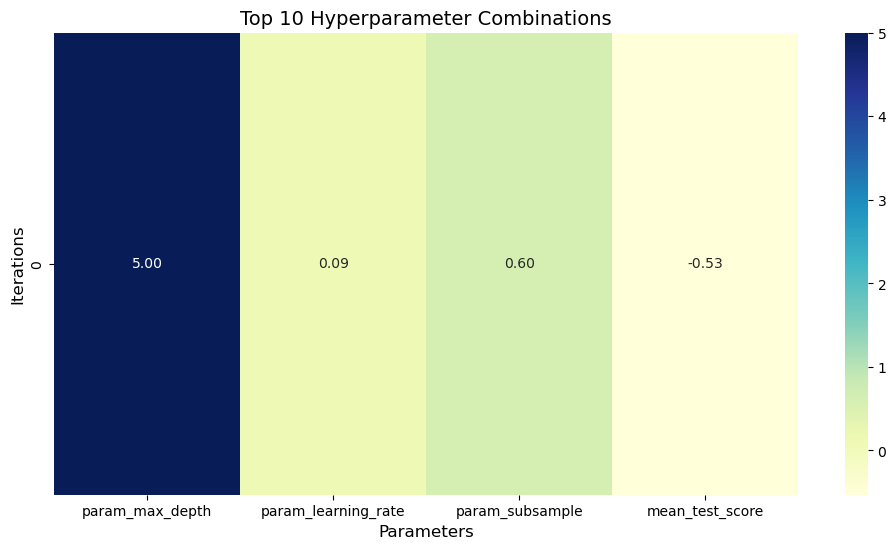

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 6. Clinical Sensitivity Analysis
plt.figure(figsize=(12,6))
sns.heatmap(pd.DataFrame(tuner.cv_results_)[
    ['param_max_depth', 'param_learning_rate', 'param_subsample', 'mean_test_score']
].sort_values('mean_test_score', ascending=False).head(10),
            annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Top 10 Hyperparameter Combinations', fontsize=14)
plt.xlabel('Parameters', fontsize=12)
plt.ylabel('Iterations', fontsize=12)
# plt.savefig('hyperparameter_tuning.png', dpi=300)
plt.show()